In [ ]:
!pip install hazm
!pip install arabic-reshaper

In [12]:
import json
import re
import pandas as pd
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import os
import hazm
from bidi.algorithm import get_display
import arabic_reshaper

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras 

from sklearn.model_selection import train_test_split


#### download original dataset from:
https://www.kaggle.com/datasets/navidkanaani/coco-flickr-farsi

In [14]:
csv_path = './dataset/coco_flickr_farsi.csv'
img_path = './dataset/coco_flickr_farsi/images'


In [15]:
dataset = pd.read_csv(csv_path,encoding='utf-8-sig')
dataset

,caption,image
0,یک گلدان با گل های قرمز و سفید در بیرون در یک ...,000000000030.jpg
1,زنی با چتر نزدیک دریا,000000000036.jpg
2,این قفسه فلزی سیمی چندین جفت کفش و صندل را در ...,000000000042.jpg
3,دو مرد سوار بر اسب هایی هستند که به عقب پرورش ...,000000000049.jpg
4,قطاری در حال توقف در کنار ریل‌ها.,000000000071.jpg
...,...,...
124183,باز هم عروسک انگشت دست عجیب و غریب، این بار با...,000024986.jpg
124184,آبشار Erawan، تایلند,000024988.jpg
124185,دختری خندان با حباب صابون,000024991.jpg
124186,بچه گربه حوالی غروب آفتاب در یک مزرعه,000024994.jpg


Text(0.5, 1.0, '.ﺪﻨﮐ ﯽﻣ ﯼﺭﺍﻮﺳ ﺝﻮﻣ ﻪﭼﺎﯾﺭﺩ ﯼﻭﺭ ﯼﺭﺍﻮﺳ ﺝﻮﻣ ﻪﺘﺨﺗ ﯼﻭﺭ ﯼﺩﺮﻣ')

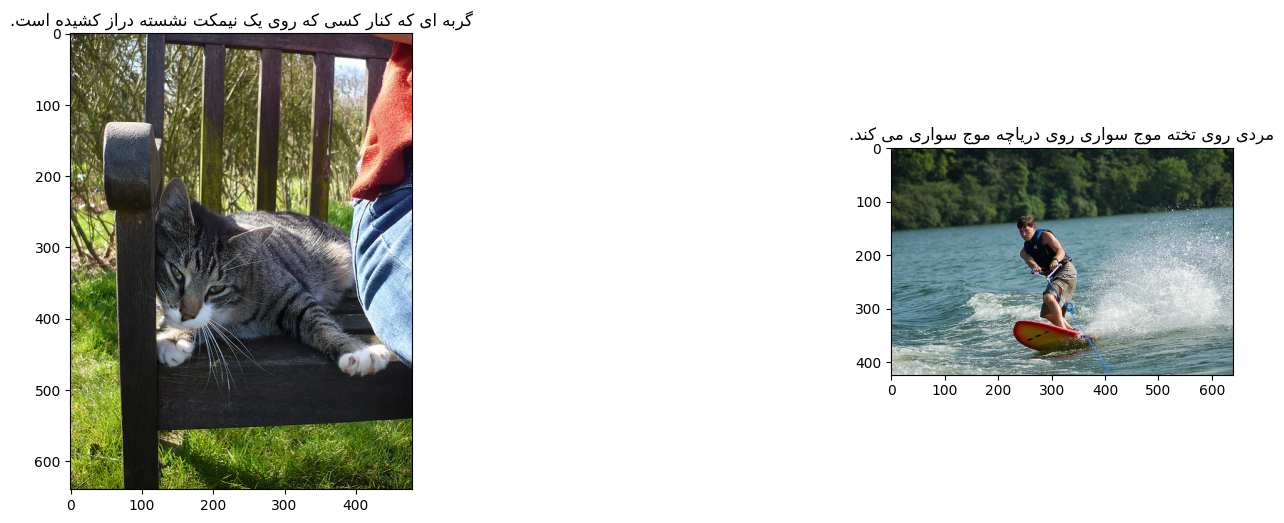

In [16]:
plt.figure(figsize=(15,12))
index = 60000
img = cv2.imread(os.path.join(img_path,dataset['image'][index]))
plt.subplot(131);plt.imshow(img[...,::-1])
text = arabic_reshaper.reshape(dataset['caption'][index])
plt.title(get_display(text))

img = cv2.imread(os.path.join(img_path,dataset['image'][index+1]))
plt.subplot(133);plt.imshow(img[...,::-1])
text = arabic_reshaper.reshape(dataset['caption'][index+1])
plt.title(get_display(text))


In [17]:
seed = 111
np.random.seed(seed)


In [18]:
dataset['caption'] = dataset['caption'].apply(lambda cap : '<شروع> ' + str(cap) + ' <پایان>')
dataset

,caption,image
0,<شروع> یک گلدان با گل های قرمز و سفید در بیرون...,000000000030.jpg
1,<شروع> زنی با چتر نزدیک دریا <پایان>,000000000036.jpg
2,<شروع> این قفسه فلزی سیمی چندین جفت کفش و صندل...,000000000042.jpg
3,<شروع> دو مرد سوار بر اسب هایی هستند که به عقب...,000000000049.jpg
4,<شروع> قطاری در حال توقف در کنار ریل‌ها. <پایان>,000000000071.jpg
...,...,...
124183,<شروع> باز هم عروسک انگشت دست عجیب و غریب، این...,000024986.jpg
124184,<شروع> آبشار Erawan، تایلند <پایان>,000024988.jpg
124185,<شروع> دختری خندان با حباب صابون <پایان>,000024991.jpg
124186,<شروع> بچه گربه حوالی غروب آفتاب در یک مزرعه <...,000024994.jpg


In [19]:
dataset['caption'][0].split()

['<شروع>',
 'یک',
 'گلدان',
 'با',
 'گل',
 'های',
 'قرمز',
 'و',
 'سفید',
 'در',
 'بیرون',
 'در',
 'یک',
 'روز',
 'آفتابی.',
 '<پایان>']

In [20]:
len(dataset['caption'][0])

72

In [21]:
print(min(dataset['caption'],key=lambda x:len(x.split())))
print(max(dataset['caption'],key=lambda x:len(x.split())))


<شروع> امید <پایان>
<شروع> در این آخر هفته کوچک در کوه‌های آلپ، به خانواده‌ام پیشنهاد دادم که به Lac du Lauzet بروند، اما هوا خوب نبود. مردم محلی به ما گفتند که در آنجا برف نخواهد آمد. به نظر می رسید که پس از 2 کیلومتر باید در عمق 10 سانتی متری برف راه برویم. 3 کیلومتر بعد برف در برخی نقاط به 30 سانتی متر و بیشتر رسید. 1 کیلومتر بعد مسیر زیر برف ناپدید شد. پدرم به خاطر فرا رسیدن شب می خواست برگردد، اما ما به او انگیزه دادیم که ادامه دهد. نتایج: او برای اولین بار وارد شد. با بازگشت، 4 کیلومتر در گل و لای، 6 کیلومتر در 10 سانتی متر برف و 6 کیلومتر در 30 سانتی متر پیاده روی کردیم. ما خیس و خسته بودیم اما به خود افتخار می کردیم و پر از خاطره <پایان>


In [22]:
sorted_captions = sorted(dataset['caption'],key=lambda cap:len(cap.split()))

In [23]:
def plot_scatter_tokens(dataset):
    token_len = dataset['caption'].apply(lambda cap:len(cap.split()))

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(token_len, bins=30, color='green', edgecolor='white')
    plt.xlabel('Token Length')
    plt.ylabel('Frequency')
    plt.subplot(132)
    plt.boxplot(token_len)
    plt.xlabel('Token Length')
    plt.ylabel('Lenght')
    plt.subplot(133)
    plt.plot(token_len)
    plt.xlabel('Tokens')
    plt.ylabel('Lenght')

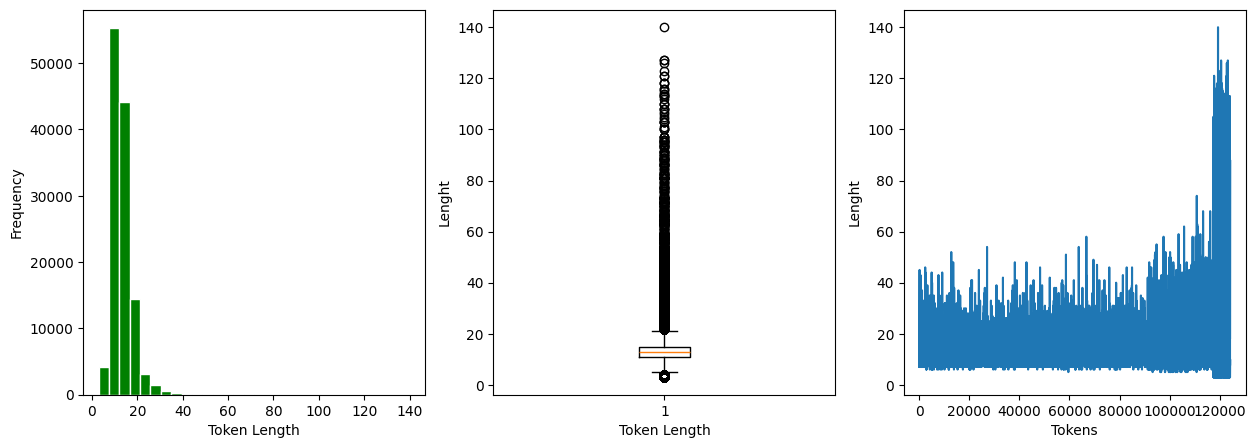

In [24]:
plot_scatter_tokens(dataset)

In [26]:
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 10000
SEQ_LENGTH = 30
EMBED_DIM = 512
FF_DIM = 512
BATCH_SIZE = 64
EPOCHS = 2
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
def dataset_split(df, dataset_len=50000, min_token=10, max_token=25, train_size=0.8, test_size = 0.1, shuffle=True): ## add assert if len dataset_len > filtered_dataset

    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)

    filterd_df = df[df['caption'].apply(lambda cap: min_token <= len(cap.split()) <= max_token )][:dataset_len]
    # print(len(filterd_df))

    train_size = int(dataset_len * train_size)
    test_size = int(dataset_len * test_size)

    train_df, test_valid_df = train_test_split(filterd_df,test_size=0.2,random_state=42)
    test_df, valid_df = train_test_split(test_valid_df,test_size=0.5,random_state=42)


    return train_df.reset_index(drop=True), valid_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [35]:
train_df, valid_df, test_df = dataset_split(dataset,dataset_len=50000)
print("Number of training samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))
print("Number of test samples: ", len(test_df))


Number of training samples:  40000
Number of validation samples:  5000
Number of test samples:  5000


In [38]:
train_df

,caption,image
0,<شروع> سبزیجات با یک کتاب روی کاغذ گذاشته می ش...,000000382210.jpg
1,<شروع> مردانی با کلاه سیاه در خیابان با یک پلی...,4671642676.jpg
2,<شروع> قطار زرد رنگ که دور از آسمان آبی از ریل...,000000272131.jpg
3,<شروع> چند نفر پشت آدم برفی ایستاده اند و اسکی...,000000105452.jpg
4,<شروع> دو پرنده مرده روی منقارهای متقاطع راه م...,000000005564.jpg
...,...,...
39995,<شروع> زنی با شلوارک و تی شرت در حال قدم زدن د...,000000216810.jpg
39996,<شروع> مردی در آسمان چیزی را تماشا می کند. <پا...,4759256692.jpg
39997,<شروع> عکس سیاه و سفید یک دختر نوجوان با عینک ...,000000397575.jpg
39998,<شروع> یک اتوبوس مسافربری در میامی با دوچرخه د...,000000451944.jpg


In [3]:
os.makedirs('./dataset/10-25_token_dataset/40K_IC')

In [44]:
train_df.to_csv('./dataset/10-25_token_dataset/40K-IC.csv',index=False)

In [48]:
import shutil
os.chdir(img_path)
def copy_img(path):
    shutil.copy(path,'./dataset/10-25_token_dataset/40K_IC')

In [49]:
train_df['image'].apply(copy_img)

0        None
1        None
2        None
3        None
4        None
         ... 
39995    None
39996    None
39997    None
39998    None
39999    None
Name: image, Length: 40000, dtype: object

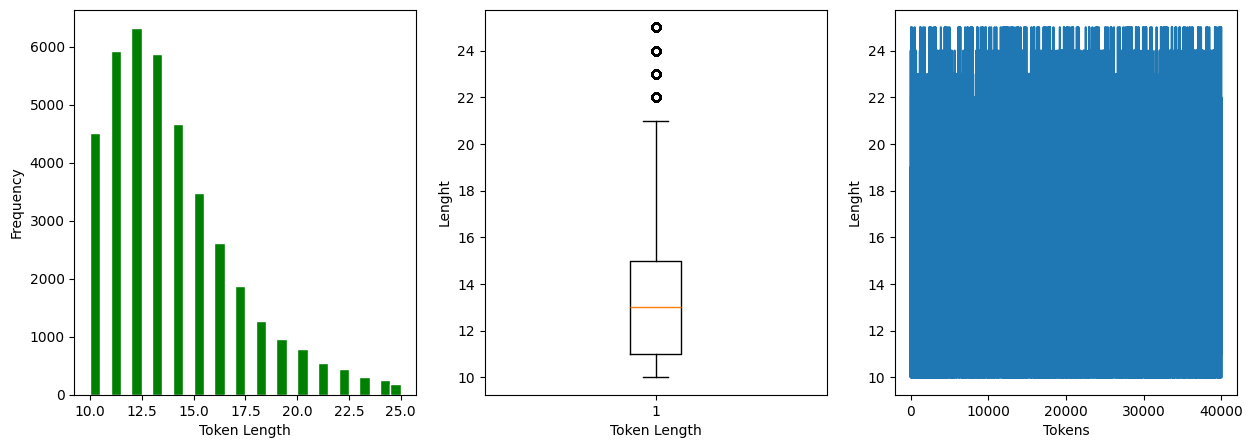

In [18]:
## check token equalized dataframes
plot_scatter_tokens(train_df)

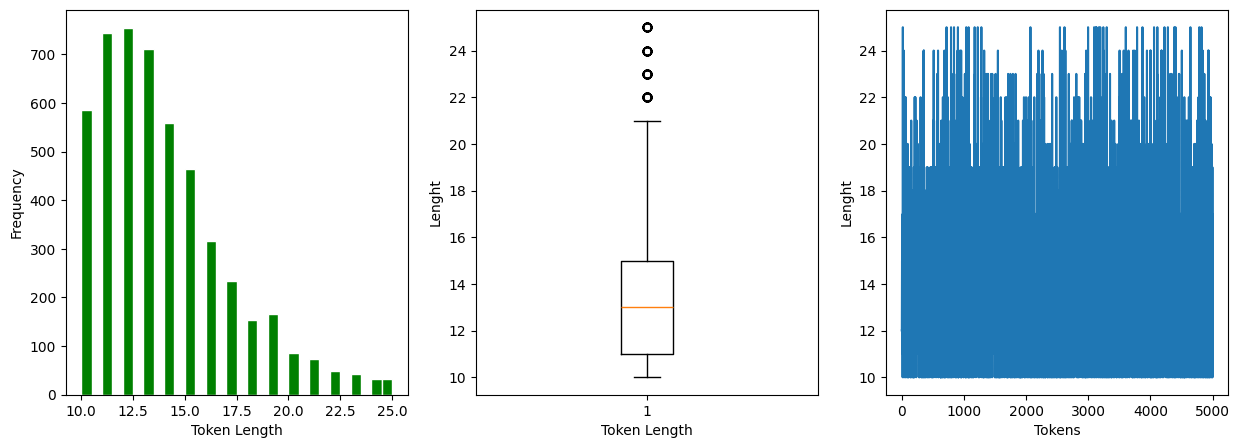

In [19]:
plot_scatter_tokens(test_df)

In [20]:
all_caption_data = dataset['caption'].str.cat()
with open('all_captions.txt','w') as file:
    file.write(all_caption_data)

In [21]:
"""
## Vectorizing the text data

We'll use the `TextVectorization` layer to vectorize the text data,
that is to say, to turn the
original strings into integer sequences where each integer represents the index of
a word in a vocabulary. We will use a custom string standardization scheme
(strip punctuation characters except `<` and `>`) and the default
splitting scheme (split on whitespace).
"""

tokenizer = hazm.WordTokenizer()
persian_tokens = tokenizer.tokenize(all_caption_data)

print('all tokens len : ', len(persian_tokens))
print('len unique tokens : ',len(set(persian_tokens)))

VOCAB_SIZE = len(set(persian_tokens))
SEQ_LENGTH = 25

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
)

vectorization.adapt(persian_tokens)


all tokens len :  1639840
len unique tokens :  18099


2023-11-15 01:18:04.034148: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 01:18:04.054161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-15 01:18:04.054718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [103]:
vocab = vectorization.get_vocabulary()
len(vocab)

17756

In [73]:
print(train_df['caption'][0])
vectorization(train_df['caption'][0])

<شروع> یک قطار قرمز و سفید در حال رفتن به یک تونل است. <پایان>


2023-11-14 16:45:14.055442: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:521] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  /home/rasoul/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/rasoul/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


<tf.Tensor: shape=(25,), dtype=int64, numpy=
array([ 744,    4,   72,   41,    7,   22,    3,   11,  329,   12,    4,
       1423,   14, 1277,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])>

In [22]:
# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomContrast(0.3),
    ]
)

In [23]:
def decode_image_and_vectorize(caption, path):
    read_path = os.path.join(img_path,path)
    img = tf.io.read_file(read_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    vcaption = vectorization(caption)

    return img, vcaption

In [24]:
"""
## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image
"""

os.chdir(img_path)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (299,299)

def decode_image_and_vectorize(caption, path):
    # read_path = os.path.join(img_path,path)
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)

    vcaption = vectorization(caption)

    return img, vcaption


def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((list(df['caption']), list(df['image'])))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(decode_image_and_vectorize, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


train_dataset = make_dataset(train_df)
valid_dataset = make_dataset(valid_df)
test_dataset = make_dataset(test_df)


In [25]:
batch = next(iter(train_dataset))
print(batch[0].shape)
print(batch[1].shape)

(32, 299, 299, 3)
(32, 25)
